<a href="https://colab.research.google.com/github/jongkwangyun/quant/blob/main/%EB%8F%99%EC%A0%81%EC%9E%90%EC%82%B0%EB%B0%B0%EB%B6%84(%2B%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8A%B8)_HAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
!pip install yfinance
!pip install pandas_market_calendars

In [114]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, Markdown
import csv
import json

# 데이터 csv 내보내기 사용 여부
is_export_csv = True

# display에서 소수점 4자리까지 표현
pd.options.display.float_format = '{:.4f}'.format

# display시 DataFrame 모든 열 표시
pd.set_option('display.max_columns', None)

# 데이터 가져올 기간을 지정합니다. (오늘로부터 12개월 전)
today = datetime.today().date()
# start_date = today - timedelta(days=375)

# 오늘 날짜 string에 저장
str_today = today.strftime('### %Y-%m-%d ')

# 전략명
str_strategy = 'HAA '

# 오늘 날짜를 가져와서 파일명에 추가
today_date = today.strftime('%y%m%d')
filename = f'{today_date} {str_strategy}.xlsx'

# csv 경로 설정
output_path =  '/content/drive/MyDrive/DynamicAssetAllocation/'

# 월평균영업일수. average Monthly Business Day
MBD = 21

# 전략에 사용할 ETF 명 리스트에 담기
etf_usa_stock = ['SPY', 'EFA']
etf_abroad_stock = ['VEA', 'VWO']
etf_bond = ['TLT', 'IEF']
etf_real = ['PDBC', 'VNQ']
etf_canary = ['TIP']
etf_bil = ['BIL']

# 자산군 리스트 더하기, 중복 제거
etf_order = list(set(etf_usa_stock + etf_abroad_stock + etf_bond + etf_real + etf_canary + etf_bil))

# ETF 가격 추출
df_etf = yf.download(etf_order, end=today)['Adj Close']\
.sort_index(ascending=False)[etf_order].rename_axis(None, axis=0).dropna()
display(df_etf)

# 1개월씩 자르기
df_etf_monthly = df_etf[::MBD]

[*********************100%%**********************]  10 of 10 completed


,VNQ,BIL,EFA,IEF,PDBC,TLT,VEA,VWO,TIP,SPY
2023-11-27,80.0500,91.7700,72.3100,92.9700,14.3000,91.3000,45.7900,40.4100,104.5500,454.4800
2023-11-24,79.7600,91.7600,72.5600,92.2700,14.4000,89.8000,45.9100,40.6000,104.2100,455.3000
2023-11-22,79.5300,91.7500,72.0100,92.7500,14.4800,90.8700,45.6100,40.4700,104.6500,455.0200
2023-11-21,79.1400,91.7100,71.8400,92.7800,14.6000,90.5500,45.5200,40.5800,104.5500,453.2700
2023-11-20,79.7000,91.6800,72.1200,92.6600,14.5250,90.5900,45.7000,40.8200,104.7700,454.2600
...,...,...,...,...,...,...,...,...,...,...
2014-11-13,55.1411,82.6916,48.9762,89.1339,12.3904,96.4295,30.1784,32.6039,90.0165,173.4986
2014-11-12,54.8413,82.7097,48.7440,88.9894,12.6628,96.2025,30.0551,32.6821,90.1202,173.3031
2014-11-11,55.2596,82.7097,49.1620,89.0234,12.6729,96.2835,30.3093,32.7760,90.2477,173.4900
2014-11-10,55.4757,82.7097,48.8679,89.0149,12.6729,96.2187,30.1321,32.7212,90.2637,173.3200


In [115]:
# 인덱스 만들기
df_momentum_index = ['today/' + str(df_etf.index[0].date()), '1mo_ago/' + str(df_etf.index[MBD].date()), \
                     '3mo_ago/' + str(df_etf.index[MBD*3].date()), '6mo_ago/' + str(df_etf.index[MBD*6].date()), \
                     '12mo_ago/' + str(df_etf.index[MBD*12].date())]


## DataFrame 만들기: 1-3-6-12 개월 etf 가격
price_today = df_etf.iloc[0:1]
price_1mo = df_etf.shift(-MBD).iloc[0:1]
price_3mo = df_etf.shift(-MBD*3).iloc[0:1]
price_6mo = df_etf.shift(-MBD*6).iloc[0:1]
price_12mo = df_etf.shift(-MBD*12).iloc[0:1]

df_price = pd.concat([price_today, price_1mo, price_3mo, price_6mo, price_12mo])
df_price.index = df_momentum_index

str_etf_price = str_today + str_strategy + "### ETF 현재-1-3-6-12 개월 가격"
display(Markdown(str_etf_price))
display(df_price)

# csv에 제목 및 DataFrame 추가. 드라이브 마운트 후 해야함
if is_export_csv:
  with open(output_path + filename, 'w') as f:
    f.write(f'{str_etf_price}\n')
    df_price.to_csv(f, index=True)

### 2023-11-28 HAA ### ETF 현재-1-3-6-12 개월 가격

,VNQ,BIL,EFA,IEF,PDBC,TLT,VEA,VWO,TIP,SPY
today/2023-11-27,80.0500,91.7700,72.3100,92.9700,14.3000,91.3000,45.7900,40.4100,104.5500,454.4800
1mo_ago/2023-10-26,72.4100,91.3722,66.0400,89.6900,14.7800,84.4401,41.7100,37.7400,102.6168,412.5500
3mo_ago/2023-08-28,80.9128,90.5888,70.9700,93.2059,14.6200,94.4107,45.0226,40.3013,104.5337,441.2037
6mo_ago/2023-05-26,77.6590,89.4217,70.8414,95.4624,13.7000,99.3169,44.7384,39.3136,105.7279,416.9947
12mo_ago/2022-11-23,82.6909,87.5310,64.8270,94.4808,14.8645,99.9411,41.5924,37.7518,104.4408,396.1832


In [116]:
## DataFrame 만들기: 모멘텀 스코어
df_etf_monthly_copy = df_etf_monthly.copy(deep=True)
df_etf_momentum_score = pd.DataFrame(index=df_etf_monthly.index, columns=df_etf_monthly.columns)

for i in range(0, len(df_etf_monthly) - 12):
  ror_1mo = df_etf_monthly_copy.pct_change(-1).iloc[0]  # 1개월 수익률
  ror_3mo = df_etf_monthly_copy.pct_change(-3).iloc[0]  # 3개월 수익률
  ror_6mo = df_etf_monthly_copy.pct_change(-6).iloc[0]  # 6개월 수익률
  ror_12mo = df_etf_monthly_copy.pct_change(-12).iloc[0]  # 12개월 수익률
  df_etf_monthly_copy.drop(df_etf_monthly_copy.index[0], inplace=True)

  # 가중치 더하기
  df_etf_momentum_score.iloc[i] = ((12 * ror_1mo) + (4 * ror_3mo) + (2 * ror_6mo) + (ror_12mo)) * 100

df_etf_momentum_score.dropna(inplace=True)
df_etf_momentum_score = df_etf_momentum_score.astype('float')

str_etf_momentum_score = str_today + str_strategy + "### ETF 별 1-3-6-12 개월 Momentum Score"
display(Markdown(str_etf_momentum_score))
display(df_etf_momentum_score)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_etf_momentum_score}\n')
    df_etf_momentum_score.head(5).to_csv(f, index=True)

### 2023-11-28 HAA ### ETF 별 1-3-6-12 개월 Momentum Score

,VNQ,BIL,EFA,IEF,PDBC,TLT,VEA,VWO,TIP,SPY
2023-11-27,125.3112,20.5350,137.1725,36.0509,-42.7654,59.5185,138.9928,98.5947,20.5455,166.6933
2023-10-26,-118.9324,20.1488,-92.7218,-53.3325,-16.6861,-147.2535,-101.9113,-87.1384,-23.6931,-65.2078
2023-09-27,-133.8204,19.7996,-32.1105,-66.3415,113.8285,-179.5831,-32.6258,-39.7592,-40.2107,-13.5708
2023-08-28,-44.2345,19.4600,-35.6375,-33.7602,15.8773,-92.2367,-38.7008,-50.9821,-25.4740,17.6234
2023-07-28,40.0588,18.8090,86.5592,-40.2086,122.9403,-79.3504,91.9726,115.4462,-13.6591,144.5476
...,...,...,...,...,...,...,...,...,...,...
2016-03-24,131.2214,0.0219,37.3116,8.1982,31.3194,29.5185,47.3170,126.2964,26.8576,82.4301
2016-02-24,-9.7999,0.2407,-82.1568,59.0795,-52.0669,104.2517,-74.4876,-9.3893,28.9341,6.2485
2016-01-25,-73.9995,-0.3500,-185.8320,34.8865,-254.1578,53.4649,-185.7783,-291.8714,-3.1947,-149.8094
2015-12-22,39.5335,-0.2844,-46.5377,9.5516,-220.4618,36.8685,-39.9035,-122.1341,-22.6535,-7.7873


In [117]:
## DataFrame 만들기: ETF 종목, 종목별 투자 비율
row_count = len(df_etf_momentum_score)
columns_num = [i for i in range(4)]
df_high_etf = pd.DataFrame(columns=columns_num, index=df_etf_momentum_score.index)
df_buy_ratio_etf = pd.DataFrame(columns=columns_num, index=df_etf_momentum_score.index)

# 마지막에 출력할 str 정의
str_buy_etf = ''
str_etf_ratio = ''
str_result_etf_bool = ''

for i in reversed(range(row_count)):
  # TIP 의 모멘텀스코어가 + 이면 공격 자산에 투자
  if df_etf_momentum_score['TIP'][i] >= 0:
    if i == 0:
      str_result_etf_bool = 'True'

    # 미국 주식, 해외 주식, 미국 국채, 대안 자산 총 8개 중 모멘텀스코어 높은 4개 종목에 투자
    df_etf_momentum_score_top4 = df_etf_momentum_score[df_etf_momentum_score.columns.difference(['TIP', 'BIL'])][i:i+1]
    df_etf_momentum_score_top4
    df_etf_momentum_score_top4.index = ['momentum_score']
    df_etf_momentum_score_top4 = df_etf_momentum_score_top4.T.nlargest(4, 'momentum_score').T
    list_etf_momentum_score_top4 = df_etf_momentum_score_top4.columns.to_list()

    str_buy_etf = ' '.join(list_etf_momentum_score_top4)
    df_high_etf.iloc[i] = list_etf_momentum_score_top4
    df_buy_ratio_etf.iloc[i] = [0.25] * 4

  # TIP 의 1-3-6-12 스코어가 - 이면 방어 자산(현금=RP)에 투자
  else:
    if i == 0:
      str_result_etf_bool = 'False'

    df_high_etf.iloc[i] = etf_bil * 4
    str_buy_etf = ''
    df_buy_ratio_etf.iloc[i] = [1, 0, 0, 0]

  # 최신 데이터로 종목 뽑기
  if i == 0:
    str_buy_etf = ' '.join(df_high_etf.iloc[i].drop_duplicates())
    str_etf_ratio = str(round(df_buy_ratio_etf[df_buy_ratio_etf > 0].iloc[i].drop_duplicates().dropna()[0] * 100)) + ' %'

str_high_etf = str_today + str_strategy + "### ETF 투자 종목 선정"
display(Markdown(str_high_etf))
display(df_high_etf)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_high_etf}\n')
    df_high_etf.head(5).to_csv(f, index=True)

### 2023-11-28 HAA ### ETF 투자 종목 선정

,0,1,2,3
2023-11-27,SPY,VEA,EFA,VNQ
2023-10-26,BIL,BIL,BIL,BIL
2023-09-27,BIL,BIL,BIL,BIL
2023-08-28,BIL,BIL,BIL,BIL
2023-07-28,BIL,BIL,BIL,BIL
...,...,...,...,...
2016-03-24,VNQ,VWO,SPY,VEA
2016-02-24,TLT,IEF,SPY,VWO
2016-01-25,BIL,BIL,BIL,BIL
2015-12-22,BIL,BIL,BIL,BIL


In [118]:
# 종목별 투자 비율
df_buy_ratio = df_buy_ratio_etf

str_buy_ratio = str_today + str_strategy + "### ETF 투자 비율"
display(Markdown(str_buy_ratio))
display(df_buy_ratio)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_buy_ratio}\n')
    df_buy_ratio.head(5).to_csv(f, index=True)

### 2023-11-28 HAA ### ETF 투자 비율

,0,1,2,3
2023-11-27,0.2500,0.2500,0.2500,0.2500
2023-10-26,1,0,0,0
2023-09-27,1,0,0,0
2023-08-28,1,0,0,0
2023-07-28,1,0,0,0
...,...,...,...,...
2016-03-24,0.2500,0.2500,0.2500,0.2500
2016-02-24,0.2500,0.2500,0.2500,0.2500
2016-01-25,1,0,0,0
2015-12-22,1,0,0,0


In [119]:
## 백테스트
monthly_column_count = df_high_etf.shape[1]
monthly_index = df_high_etf.index

# 비율대로 돈 투자
df_invest_money = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_invest_count = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_cash = pd.DataFrame(columns=['cash'], index=monthly_index)

# 초기자본
invest_cash = 10_000

for i in reversed(range(row_count)):
  row_sum = 0

  for j in range(monthly_column_count):
    if i == row_count - 1:
      row_sum = invest_cash
      break
    else:
      sel_etf = df_high_etf.iloc[i+1][j]
      row_sum += df_invest_count.iloc[i+1][j] * df_etf_monthly.iloc[i][sel_etf]

  for j in range(monthly_column_count):
    df_cash.iloc[i][0] = row_sum
    sel_etf = df_high_etf.iloc[i][j]
    sel_etf_price = df_etf_monthly.iloc[i][sel_etf]
    sel_etf_buy_count = df_cash.iloc[i][0] * df_buy_ratio.iloc[i][j] / sel_etf_price
    df_invest_count.iloc[i][j] = sel_etf_buy_count

display(Markdown(str_today + str_strategy + '### ETF 구매 개수'))
display(df_invest_count)
display(Markdown(str_today + str_strategy + '### 평가 금액'))
display(df_cash)

CAGR = str(round(((df_cash.iloc[0][0] / df_cash.iloc[-1][0]) ** (12/(row_count-1)) - 1)*100, 2))
display(Markdown(f'{str_today[1:]} {str_strategy} ## CAGR: {CAGR} %'))

### 2023-11-28 HAA ### ETF 구매 개수

,0,1,2,3
2023-11-27,11.9612,118.7186,75.1781,67.9091
2023-10-26,236.9457,0.0000,0.0000,0.0000
2023-09-27,236.9457,0.0000,0.0000,0.0000
2023-08-28,236.9457,0.0000,0.0000,0.0000
2023-07-28,236.9457,0.0000,0.0000,0.0000
...,...,...,...,...
2016-03-24,42.9520,94.3566,14.5213,91.5666
2016-02-24,22.7706,25.9881,14.8425,100.4833
2016-01-25,121.0901,0.0000,0.0000,0.0000
2015-12-22,121.0901,0.0000,0.0000,0.0000


### 2023-11-28 HAA ### 평가 금액

,cash
2023-11-27,21744.5031
2023-10-26,21650.2415
2023-09-27,21557.3393
2023-08-28,21464.6342
2023-07-28,21372.5093
...,...
2016-03-24,10341.2670
2016-02-24,10002.1886
2016-01-25,10000.0000
2015-12-22,10000.0000


## 2023-11-28  HAA  ## CAGR: 10.2 %

In [120]:
## 결과 출력
display(Markdown(str_today[1:] + str_strategy))

str_result_etf = '## TIP 의 모멘텀스코어가 0 이상인가?: ' + str_result_etf_bool
display(Markdown(str_result_etf))

str_result_buy = '## 구매할 자산: ' + str_buy_etf
display(Markdown(str_result_buy))

str_result_ratio = '## 각각 구매 비율: ' + str_etf_ratio
display(Markdown(str_result_ratio))

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_today[1:] + str_strategy}\n')
    f.write(f'{str_result_etf}\n')
    f.write(f'{str_result_buy}\n')
    f.write(f'{str_result_ratio}\n')

## 2023-11-28 HAA 

## TIP 의 모멘텀스코어가 0 이상인가?: True

## 구매할 자산: SPY VEA EFA VNQ

## 각각 구매 비율: 25 %

<Axes: >

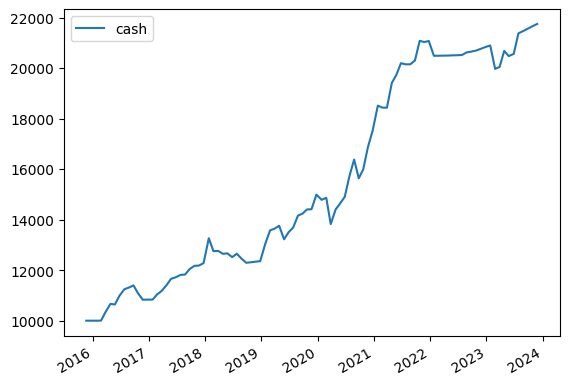

In [121]:
df_cash.plot()